In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
fs = 48000
N = 2048

In [8]:
#bark scale
def bark(f):
    return 13*np.arctan(.76*f/1000)+3.5*np.arctan((f/7500)**2)

def get_subband_index(f):
    return int(bark(f))

def bin_to_subband_index(k, fs=48000, N=2048):
    return 1 + int(bark(k * fs / N))

In [9]:
print(bin_to_subband_index(0, 8000, N))
print(bin_to_subband_index(2048, 8000, N))
print(bin_to_subband_index(1023, 48000, N))

1
22
25


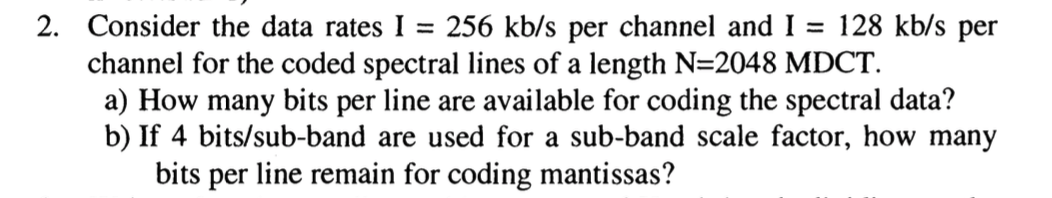

In [10]:
def R_k(data_rate, fs):
    return data_rate / fs

def block_bits_per_channel(R_k, N) :
    return R_k * N / 2

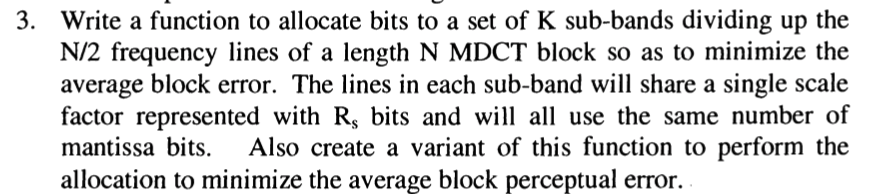

In [15]:
K = 25
k_map = {k:0 for k in range(1, K+1)}

for bin in range(N//2): 
    k = bin_to_subband_index(bin, fs, N)
    k_map[k] = k_map[k] + 1
k_map

{1: 5,
 2: 4,
 3: 5,
 4: 4,
 5: 5,
 6: 5,
 7: 6,
 8: 6,
 9: 7,
 10: 7,
 11: 9,
 12: 10,
 13: 11,
 14: 15,
 15: 17,
 16: 22,
 17: 26,
 18: 31,
 19: 36,
 20: 43,
 21: 52,
 22: 66,
 23: 96,
 24: 171,
 25: 365}

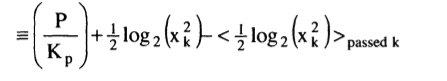

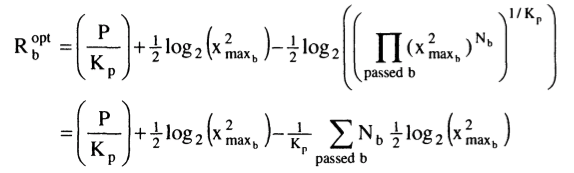

In [147]:
def bit_allocation_greedy(K_p, P, N_b, xmax_b):
    
    avg = np.sum(0.5 * np.array(N_b) * np.log2(xmax_b ** 2))/K_p
    buffer = np.array((P/K_p) + 0.5 * np.array(N_b) * np.log2(xmax_b ** 2) - avg)
    
    positives = np.ones_like(buffer)
    while np.any(buffer < 0):
        positives[np.nonzero(buffer < 0)[0]] = 0
        K_p = np.count_nonzero(positives)
        
        avg = np.sum(0.5 * np.array(N_b) * np.log2(xmax_b ** 2) * positives) / K_p
        buffer = np.array((P/K_p) + 0.5 * np.array(N_b) * np.log2(xmax_b ** 2) - avg) * positives
        
    return buffer

In [148]:
total_bits = int(block_bits_per_channel(R_k(256000, fs), N) - 100)
samples = np.random.rand(K)
allocation = bit_allocation_greedy(K, total_bits, np.array(list(k_map.values())), samples) 
allocation

array([256.59856231, 269.05488198, 269.33843215, 263.76790384,
       265.3307498 , 261.88518493, 220.47925702, 269.20290554,
       261.8975547 , 256.86739733, 259.70645486, 267.8955694 ,
       219.35309074, 263.47348151, 256.55775325, 239.16844116,
       234.27275465, 251.48943688, 200.55206594, 161.8571377 ,
        33.22883499, 219.37202372, 137.058655  ,  22.5914706 ,
        -0.        ])

In [149]:
np.sum(allocation)

5361.0

In [151]:
class MDCT():
    def __init__(self, N: int, window: np.ndarray):
        K = N//2
        self.n_0 = ((N/2) + 1)/2

        A = np.zeros((K,N))
        for k in range(K):
            for n in range(N):
                A[k,n] = np.cos((2*np.pi/N)*(n + self.n_0)*(k+1/2))

        self.N = N
        self.window = window
        self.A_1 = A[:,:N//2]
        self.A_2 = A[:,N//2:]
        self.B_1 = (4/N)*self.A_1.T
        self.B_2 = (4/N)*self.A_2.T

        self.A = A
        self.B = (4/N)*A.T

        if window.shape[0] != N:
            raise ValueError(f"Window is not the same size as N! Window size: {window.shape[0]}")

    def _preprocess(self, x: np.ndarray):
        L = len(x)
        self.frames = L//(self.N//2) + 1
        r = L%(self.N//2)
        return np.pad(x, (self.N // 2, self.N // 2 - r))


    def mdct(self, x: np.ndarray):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = self.A @ (frame * self.window)

        return X

    def imdct(self, X: np.ndarray):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += (self.B @ X[:,frame_idx]) * self.window
            
        return x_padded[self.N//2:-self.N//2]
    
    def mdct_pre_twiddle(self):
        return np.exp(-2j * np.pi * np.arange(self.N) / (2*self.N))

    def mdct_post_twiddle(self):
        return np.exp(-2j * np.pi * self.n_0 * (np.arange(self.N//2) + 0.5) / self.N)


    def mdct_via_fft(self, x):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = np.real(
                self.mdct_post_twiddle() * np.fft.fft(frame * self.window * self.mdct_pre_twiddle())[:self.N//2]
            )
        
        return X 
    
    def imdct_pre_twiddle(self):
        return np.exp(2j * np.pi * self.n_0 * np.arange(self.N) / self.N)

    def imdct_post_twiddle(self):
        return np.exp(2j * np.pi * (np.arange(self.N) + self.n_0) / (2*self.N))
    
    def imdct_via_ifft(self, X):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += \
            np.real(np.fft.ifft(np.concatenate((X[:,frame_idx], -X[::-1,frame_idx])) * self.imdct_pre_twiddle()) * \
            self.imdct_post_twiddle()) * 2 * self.window
            
        return x_padded[self.N//2:-self.N//2]
        
def sine_window(N):
    M = N//2
    w = np.zeros((N,1))

    for n in range(N-M):
        w[n] = np.sin((np.pi/2)*(n+1/2)/(N-M))
        
    for n in range(N-M,M):
        w[n] = 1

    for n in range(M,N):
        w[n] = np.sin((np.pi/2)*(N - n - 1/2)/(N-M))

    return w.reshape(-1)

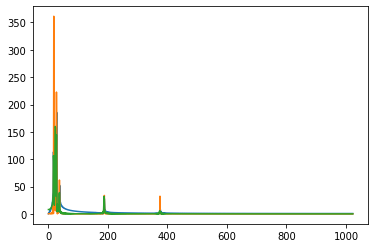

In [152]:
n = np.arange(N)
T = N/fs
t = np.linspace(0, T, N)

A0 = 0.6
A1 = 0.55
A2 = 0.55
A3 = 0.15
A4 = 0.1
A5 = 0.05


x = A0 * np.cos(2 * np.pi * n * 440/fs)  \
  + A1 * np.cos(2 * np.pi * n * 554/fs)  \
  + A2 * np.cos(2 * np.pi * n * 660/fs)  \
  + A3 * np.cos(2 * np.pi * n * 880/fs)  \
  + A4 * np.cos(2 * np.pi * n * 4400/fs) \
  + A5 * np.cos(2 * np.pi * n * 8800/fs)

my_mdct = MDCT(N, sine_window(N))

X = my_mdct.mdct(x)
plt.plot(np.abs(X))

# bit_allocation(K, total_bits, list(k_map.values()), np.abs(X) 

In [153]:
df = pd.DataFrame({'bin': range(1024), 'mdct': X[:, 1]})
df["subband"] = df["bin"].apply(bin_to_subband_index)
df.drop(columns = ["bin"], inplace = True)
x_max_b = df.groupby(by=["subband"]).max()["mdct"].to_numpy()
list(x_max_b)

[0.4966768818833803,
 0.7429672999517216,
 1.4116945568944876,
 4.456689101729536,
 76.52147206841722,
 132.06992533949497,
 27.645872037711957,
 28.55540551915366,
 1.366376183452271,
 0.2702751073171819,
 0.1867925665061234,
 0.09195786851856802,
 0.06572046508932601,
 0.04418524341496753,
 0.02961584693490034,
 0.02221436460617579,
 0.027652634286610876,
 20.666898274915138,
 0.10499554135524351,
 0.009644693284610107,
 0.005523728201437539,
 32.38106678658765,
 0.026285635391936697,
 0.0015148725712350597,
 0.0005077970079349209]

In [154]:
alloc = bit_allocation_greedy(K, total_bits, np.array(list(k_map.values())), x_max_b)
alloc

array([265.03136607, 268.36495104, 272.56660842, 278.70335785,
       301.36843217, 305.30525939, 298.81342161, 299.09362037,
       273.2319517 , 256.8669724 , 248.2950491 , 235.65063693,
       226.87682006, 202.57509519, 183.76219218, 149.24747567,
       135.49204763, 405.52621787, 153.02186749,  -0.        ,
        -0.        , 601.20665686,  -0.        ,  -0.        ,
        -0.        ])

In [155]:
np.sum(alloc)

5361.0